Phân tích thị trường bất động sản TP.HCM sử dụng thuật toán K-means

Đề tài 15: Phân tích thị trường bất động sản (clustering)

Thuật toán: K-means

Dataset: Ho Chi Minh City Real Estate.csv

In [3]:
# Cài đặt các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import re
import warnings
warnings.filterwarnings('ignore')

# Thiết lập hiển thị tiếng Việt
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 1. Đọc dữ liệu
df = pd.read_csv('Ho Chi Minh City Real Estate.csv')
print(f"Số lượng dòng: {df.shape[0]}")
print(f"Số lượng cột: {df.shape[1]}")
df.head()

Số lượng dòng: 2015
Số lượng cột: 5


,Unnamed: 0,title,area,price,location
0,0,"Prosper Plaza DT50m2 giá 1.9 tỷ, DT65m2 gía 2.15",65 m² - 2 PN,"2,15 tỷ",Quận 12
1,1,"Căn Hộ Prosper Phan Văn Hớn Có Sổ Giá Chỉ 1,85...",54 m² - 2 PN,"1,85 tỷ",Quận 12
2,2,"chuyên bán căn hộ sky9, 1,2,3pn giá từ 900tr >...",53 m² - 2 PN,"1,6 tỷ",Quận 9 - Thành phố Thủ Đức
3,3,Căn hộ tẩng 33 River Gate Q.4 74m2. 2PN 2WC B...,75 m² - 2 PN,"4,6 tỷ",Quận 4
4,4,DIAMOND RIVERSIDE MỚI CAO CẤP 3 PN 2.850 Tỷ,84 m² - 3 PN,"2,85 tỷ",Quận 8


In [5]:
# 2. Kiểm tra và xử lý dữ liệu
# Kiểm tra giá trị null
print("\nKiểm tra giá trị null:")
print(df.isnull().sum())

# Xử lý dữ liệu diện tích (area)
def extract_area(area_str):
    if pd.isna(area_str):
        return np.nan
    match = re.search(r'(\d+)', str(area_str))
    if match:
        return float(match.group(1))
    return np.nan

df['area_m2'] = df['area'].apply(extract_area)

# Xử lý dữ liệu giá (price)
def extract_price(price_str):
    if pd.isna(price_str):
        return np.nan
    # Nếu có đơn vị tỷ
    if 'tỷ' in str(price_str):
        match = re.search(r'([\d,]+)', str(price_str))
        if match:
            # Thay thế dấu phẩy thành dấu chấm để chuyển đổi sang float
            price_str = match.group(1).replace(',', '.')
            return float(price_str)
    # Nếu có đơn vị triệu
    elif 'triệu' in str(price_str) or 'tr' in str(price_str):
        match = re.search(r'([\d,]+)', str(price_str))
        if match:
            price_str = match.group(1).replace(',', '.')
            return float(price_str) / 1000  # Chuyển triệu thành tỷ
    # Trường hợp khác
    else:
        match = re.search(r'([\d,]+)', str(price_str))
        if match:
            price_str = match.group(1).replace(',', '.')
            if float(price_str) > 100:
                return float(price_str) / 1000  # Chuyển triệu thành tỷ
            return float(price_str)
    return np.nan

df['price_billion'] = df['price'].apply(extract_price)

# Xác định số phòng ngủ từ cột area
def extract_bedroom(area_str):
    if pd.isna(area_str):
        return np.nan
    match = re.search(r'(\d+)\s*PN', str(area_str))
    if match:
        return int(match.group(1))
    return np.nan

df['bedrooms'] = df['area'].apply(extract_bedroom)


Kiểm tra giá trị null:
Unnamed: 0    0
title         0
area          0
price         0
location      0
dtype: int64


In [6]:
# 3. Xử lý dữ liệu location
# Đơn giản hóa tên các quận
def simplify_location(location):
    if pd.isna(location):
        return "Unknown"
    location = str(location).lower()
    if 'quận 1' in location:
        return 'Quận 1'
    elif 'quận 2' in location or 'thủ đức' in location:
        return 'Quận 2 - Thủ Đức'
    elif 'quận 3' in location:
        return 'Quận 3'
    elif 'quận 4' in location:
        return 'Quận 4'
    elif 'quận 5' in location:
        return 'Quận 5'
    elif 'quận 6' in location:
        return 'Quận 6'
    elif 'quận 7' in location:
        return 'Quận 7'
    elif 'quận 8' in location:
        return 'Quận 8'
    elif 'quận 9' in location:
        return 'Quận 9'
    elif 'quận 10' in location:
        return 'Quận 10'
    elif 'quận 11' in location:
        return 'Quận 11'
    elif 'quận 12' in location:
        return 'Quận 12'
    elif 'bình thạnh' in location:
        return 'Quận Bình Thạnh'
    elif 'phú nhuận' in location:
        return 'Quận Phú Nhuận'
    elif 'tân bình' in location:
        return 'Quận Tân Bình'
    elif 'tân phú' in location:
        return 'Quận Tân Phú'
    elif 'gò vấp' in location:
        return 'Quận Gò Vấp'
    elif 'bình tân' in location:
        return 'Quận Bình Tân'
    elif 'nhà bè' in location:
        return 'Huyện Nhà Bè'
    elif 'hóc môn' in location:
        return 'Huyện Hóc Môn'
    elif 'củ chi' in location:
        return 'Huyện Củ Chi'
    elif 'bình chánh' in location:
        return 'Huyện Bình Chánh'
    elif 'cần giờ' in location:
        return 'Huyện Cần Giờ'
    else:
        return 'Khác'
df['location_cleaned'] = df['location'].apply(simplify_location)

In [11]:
# 4. Làm sạch dữ liệu và đảm bảo mọi thứ đều sẵn sàng cho phân tích
# Loại bỏ các hàng có giá trị null trong các cột chính
df_clean = df.dropna(subset=['area_m2', 'price_billion'])

# Hiển thị thông tin sau khi làm sạch
print("\nThông tin sau khi làm sạch:")
print(f"Số lượng dòng: {df_clean.shape[0]}")
print(f"Số lượng cột: {df_clean.shape[1]}")

# Hiển thị thống kê cơ bản
print("\nThống kê cơ bản:")
print(df_clean[['area_m2', 'price_billion', 'bedrooms']].describe())


Thông tin sau khi làm sạch:
Số lượng dòng: 2015
Số lượng cột: 9

Thống kê cơ bản:
           area_m2  price_billion     bedrooms
count  2015.000000    2015.000000  2015.000000
mean     75.095782       3.937290     2.090323
std      56.259888      25.696975     0.758128
min       1.000000       0.001000     1.000000
25%      57.000000       1.785000     2.000000
50%      68.000000       2.350000     2.000000
75%      80.000000       3.309500     2.000000
max    1500.000000     800.000000    10.000000


Text(0, 0.5, 'Số lượng')

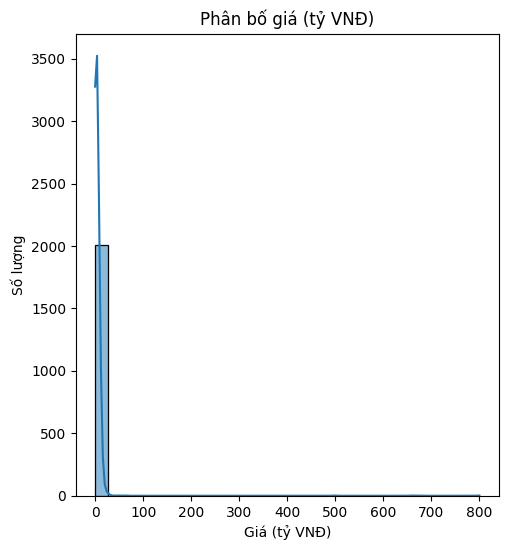

In [12]:
# 5. Phân tích EDA (Exploratory Data Analysis)
# Phân tích phân bố giá
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['price_billion'], bins=30, kde=True)
plt.title('Phân bố giá (tỷ VNĐ)')
plt.xlabel('Giá (tỷ VNĐ)')
plt.ylabel('Số lượng')

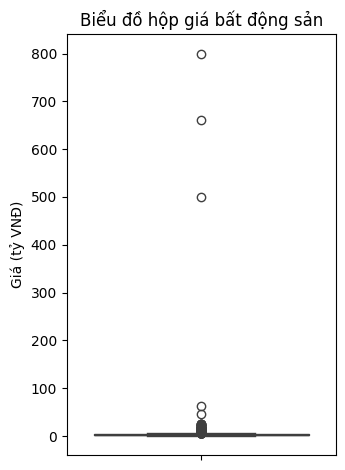

In [13]:
# Vẽ biểu đồ hộp về giá của BDS
plt.subplot(1, 2, 2)
sns.boxplot(y=df_clean['price_billion'])
plt.title('Biểu đồ hộp giá bất động sản')
plt.ylabel('Giá (tỷ VNĐ)')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Số lượng')

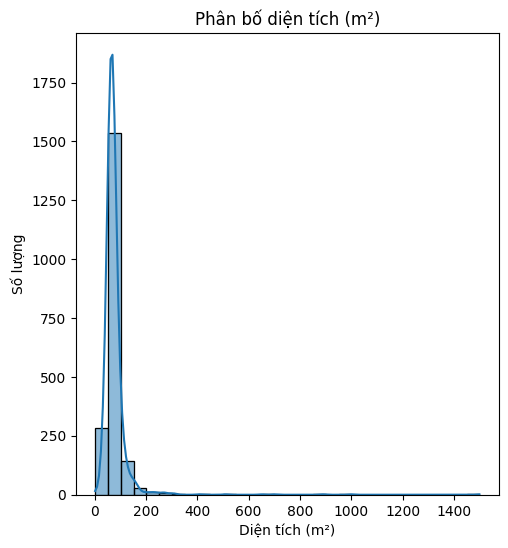

In [14]:
# Phân tích phân bố diện tích
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['area_m2'], bins=30, kde=True)
plt.title('Phân bố diện tích (m²)')
plt.xlabel('Diện tích (m²)')
plt.ylabel('Số lượng')

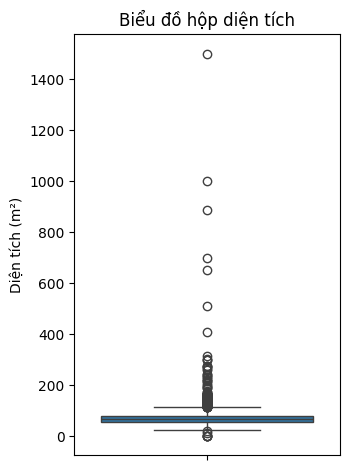

In [15]:
# Vẽ biểu đồ hộp về diện tích BDS
plt.subplot(1, 2, 2)
sns.boxplot(y=df_clean['area_m2'])
plt.title('Biểu đồ hộp diện tích')
plt.ylabel('Diện tích (m²)')
plt.tight_layout()
plt.show()

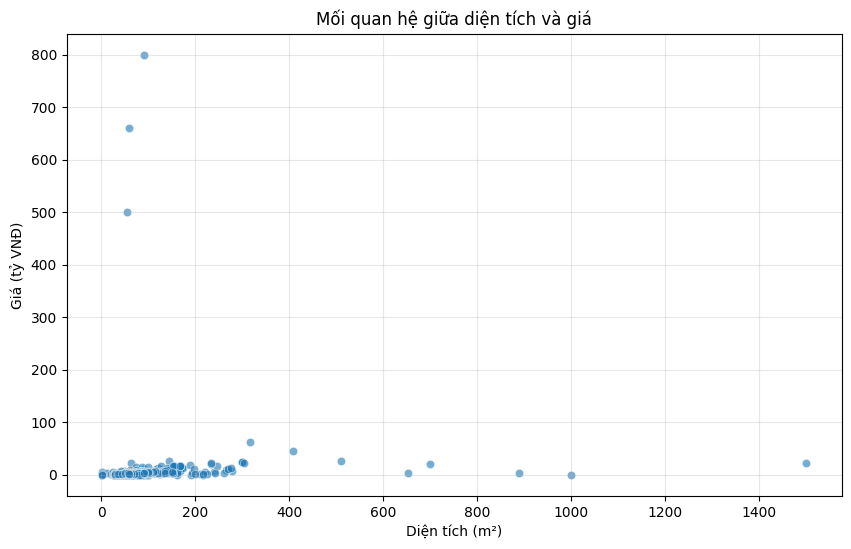

In [16]:
# Xem xét mối quan hệ giữa diện tích và giá
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area_m2', y='price_billion', data=df_clean, alpha=0.6)
plt.title('Mối quan hệ giữa diện tích và giá')
plt.xlabel('Diện tích (m²)')
plt.ylabel('Giá (tỷ VNĐ)')
plt.grid(True, alpha=0.3)
plt.show()

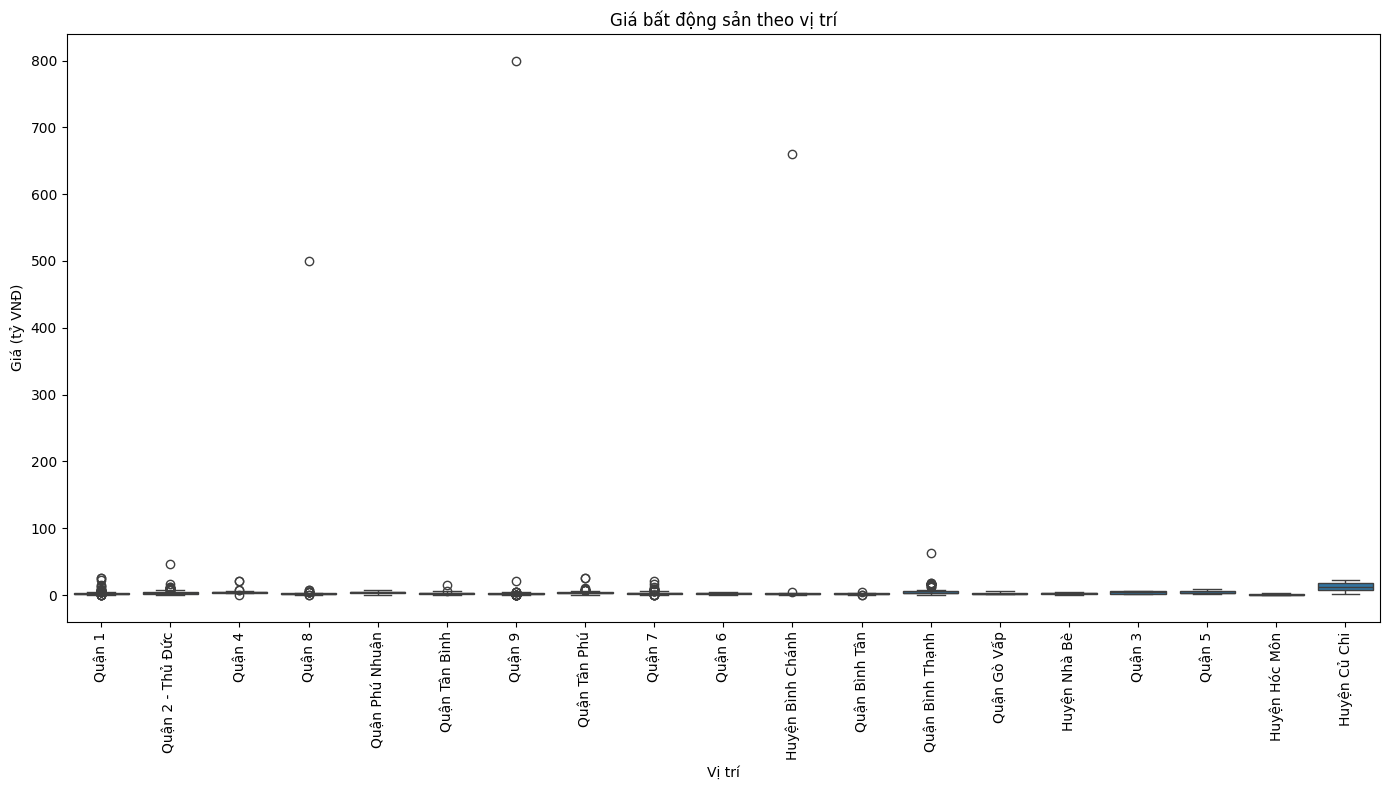

In [17]:
# Phân tích giá theo vị trí
plt.figure(figsize=(14, 8))
sns.boxplot(x='location_cleaned', y='price_billion', data=df_clean)
plt.title('Giá bất động sản theo vị trí')
plt.xlabel('Vị trí')
plt.ylabel('Giá (tỷ VNĐ)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

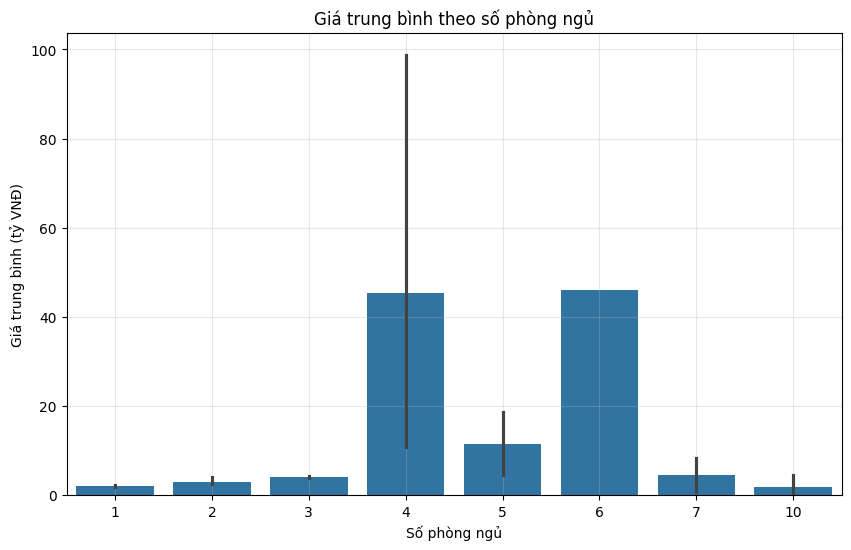

In [18]:
# Giá trung bình theo phòng ngủ
plt.figure(figsize=(10, 6))
sns.barplot(x='bedrooms', y='price_billion', data=df_clean)
plt.title('Giá trung bình theo số phòng ngủ')
plt.xlabel('Số phòng ngủ')
plt.ylabel('Giá trung bình (tỷ VNĐ)')
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# 6. Chuẩn bị dữ liệu cho thuật toán K-means
# Chọn các đặc trưng để phân cụm
features = df_clean[['area_m2', 'price_billion']]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [20]:
# 7. Xác định số cụm tối ưu bằng phương pháp Elbow Method
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

    # Tính silhouette score
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(features_scaled, labels)
    silhouette_scores.append(silhouette_avg)

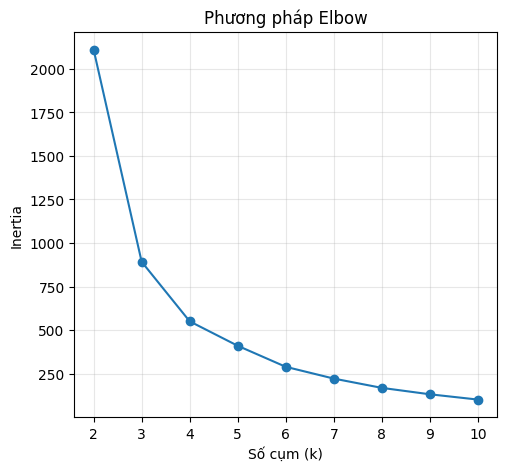

In [21]:
# Vẽ biểu đồ Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Phương pháp Elbow')
plt.xlabel('Số cụm (k)')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)

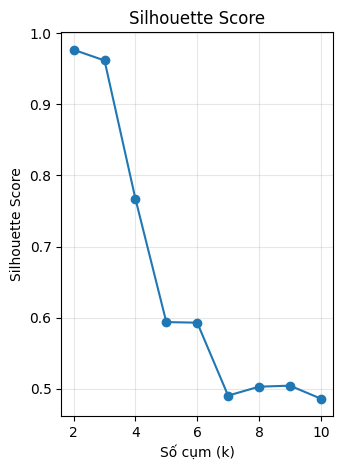

In [22]:
# Vẽ biểu đồ Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Số cụm (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
# 8. Áp dụng thuật toán K-means với số cụm tối ưu
# Từ biểu đồ, chọn số cụm tối ưu
optimal_k = 5

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_clean['cluster'] = kmeans.fit_predict(features_scaled)

In [24]:
# 9. Phân tích kết quả
# Kiểm tra các cụm
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=['area_m2', 'price_billion'])
cluster_centers_df['cluster'] = range(optimal_k)

print("\nTrung tâm các cụm:")
print(cluster_centers_df)

# Thống kê các cụm
cluster_stats = df_clean.groupby('cluster').agg({
    'area_m2': ['mean', 'min', 'max', 'count'],
    'price_billion': ['mean', 'min', 'max'],
    'bedrooms': ['mean', 'median']
})

print("\nThống kê các cụm:")
print(cluster_stats)


Trung tâm các cụm:
      area_m2  price_billion  cluster
0   61.632484       2.283036        0
1   67.666667     653.333333        1
2  948.000000       9.954000        2
3  259.407407      13.674985        3
4  103.921951       4.805558        4

Thống kê các cụm:
            area_m2                      price_billion                       \
               mean    min     max count          mean       min        max   
cluster                                                                       
0         61.686785    1.0    83.0  1574      2.283937    0.0010   22.00000   
1         67.666667   54.0    90.0     3    653.333333  500.0000  800.00000   
2        948.000000  652.0  1500.0     5      9.954000    0.2500   23.00000   
3        259.407407  188.0   510.0    27     13.674985    0.0092   62.60000   
4        104.128079   83.0   174.0   406      4.826918    0.0035   25.97535   

         bedrooms         
             mean median  
cluster                   
0        1.871029  

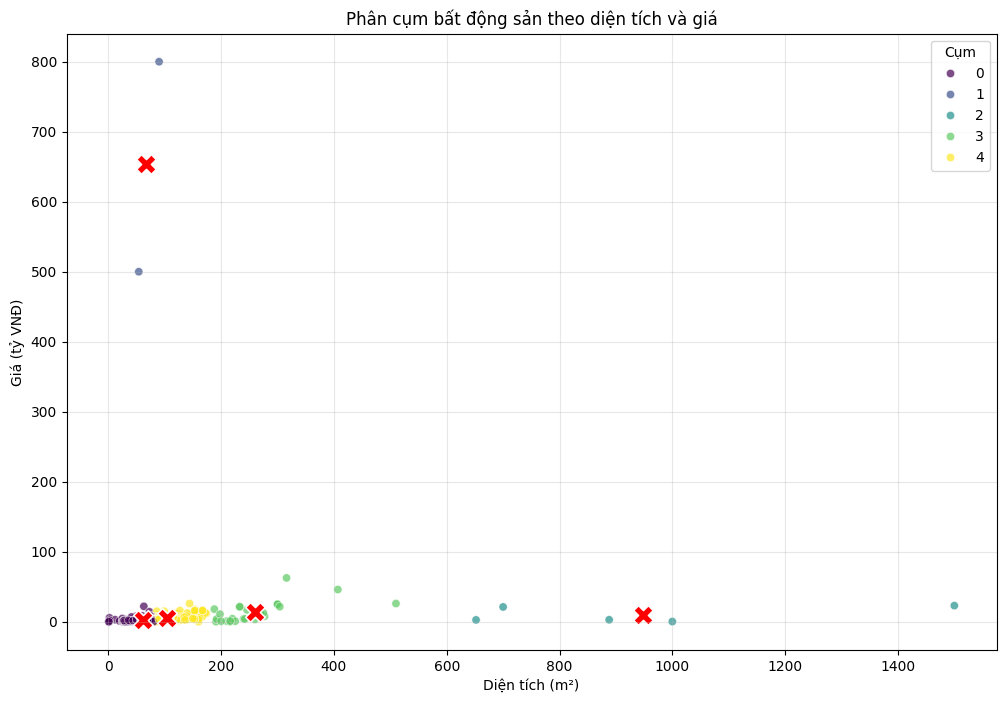

In [25]:
# 10. Trực quan hóa kết quả phân cụm
plt.figure(figsize=(12, 8))
sns.scatterplot(x='area_m2', y='price_billion', hue='cluster', data=df_clean, palette='viridis', alpha=0.7)
sns.scatterplot(x='area_m2', y='price_billion', data=cluster_centers_df, s=200, color='red', marker='X')
plt.title('Phân cụm bất động sản theo diện tích và giá')
plt.xlabel('Diện tích (m²)')
plt.ylabel('Giá (tỷ VNĐ)')
plt.grid(True, alpha=0.3)
plt.legend(title='Cụm')
plt.show()

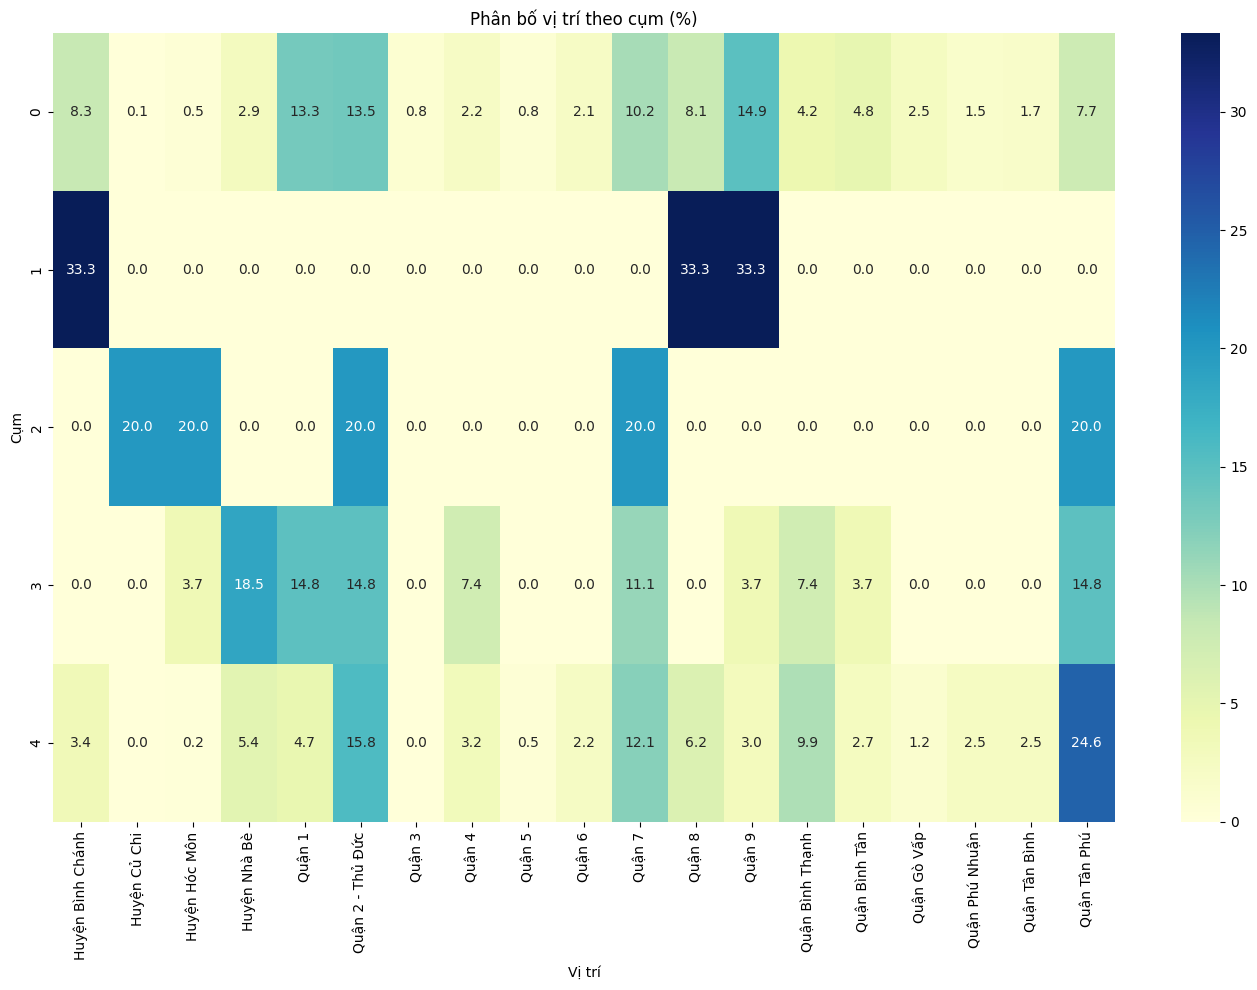

In [26]:
# 11. Phân tích phân bố vị trí theo cụm
plt.figure(figsize=(14, 10))
crosstab = pd.crosstab(df_clean['cluster'], df_clean['location_cleaned'])
crosstab_percent = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
sns.heatmap(crosstab_percent, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Phân bố vị trí theo cụm (%)')
plt.xlabel('Vị trí')
plt.ylabel('Cụm')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [27]:
# 12. Phân tích chi tiết từng cụm từ biểu đồ nhiệt
for i in range(optimal_k):
    cluster_data = df_clean[df_clean['cluster'] == i]
    print(f"\nCụm {i}:")
    print(f"Số lượng bất động sản: {len(cluster_data)}")
    print(f"Diện tích trung bình: {cluster_data['area_m2'].mean():.2f} m²")
    print(f"Giá trung bình: {cluster_data['price_billion'].mean():.2f} tỷ VNĐ")
    print(f"Số phòng ngủ trung bình: {cluster_data['bedrooms'].mean():.2f}")
    print("Top 5 vị trí phổ biến:")
    print(cluster_data['location_cleaned'].value_counts().head())


Cụm 0:
Số lượng bất động sản: 1574
Diện tích trung bình: 61.69 m²
Giá trung bình: 2.28 tỷ VNĐ
Số phòng ngủ trung bình: 1.87
Top 5 vị trí phổ biến:
location_cleaned
Quận 9              235
Quận 2 - Thủ Đức    212
Quận 1              209
Quận 7              161
Huyện Bình Chánh    130
Name: count, dtype: int64

Cụm 1:
Số lượng bất động sản: 3
Diện tích trung bình: 67.67 m²
Giá trung bình: 653.33 tỷ VNĐ
Số phòng ngủ trung bình: 3.33
Top 5 vị trí phổ biến:
location_cleaned
Quận 8              1
Huyện Bình Chánh    1
Quận 9              1
Name: count, dtype: int64

Cụm 2:
Số lượng bất động sản: 5
Diện tích trung bình: 948.00 m²
Giá trung bình: 9.95 tỷ VNĐ
Số phòng ngủ trung bình: 2.20
Top 5 vị trí phổ biến:
location_cleaned
Quận 2 - Thủ Đức    1
Quận Tân Phú        1
Huyện Hóc Môn       1
Huyện Củ Chi        1
Quận 7              1
Name: count, dtype: int64

Cụm 3:
Số lượng bất động sản: 27
Diện tích trung bình: 259.41 m²
Giá trung bình: 13.67 tỷ VNĐ
Số phòng ngủ trung bình: 4.41
Top 5 vị 

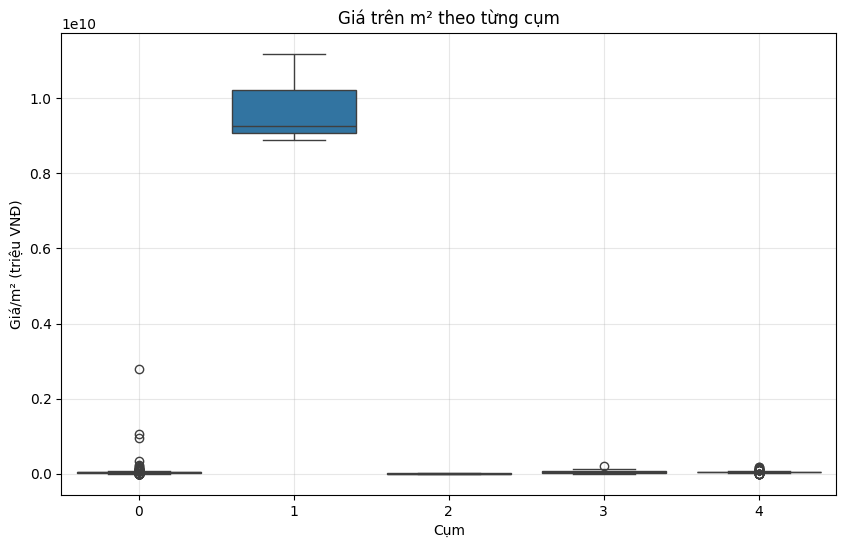

In [28]:
# 13. Phân tích tính năng của từng cụm
# Tính giá trung bình trên m² của mỗi cụm
df_clean['price_per_m2'] = df_clean['price_billion'] * 1000000000 / df_clean['area_m2']  # Giá/m² (VNĐ)

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='price_per_m2', data=df_clean)
plt.title('Giá trên m² theo từng cụm')
plt.xlabel('Cụm')
plt.ylabel('Giá/m² (triệu VNĐ)')
plt.grid(True, alpha=0.3)
plt.show()

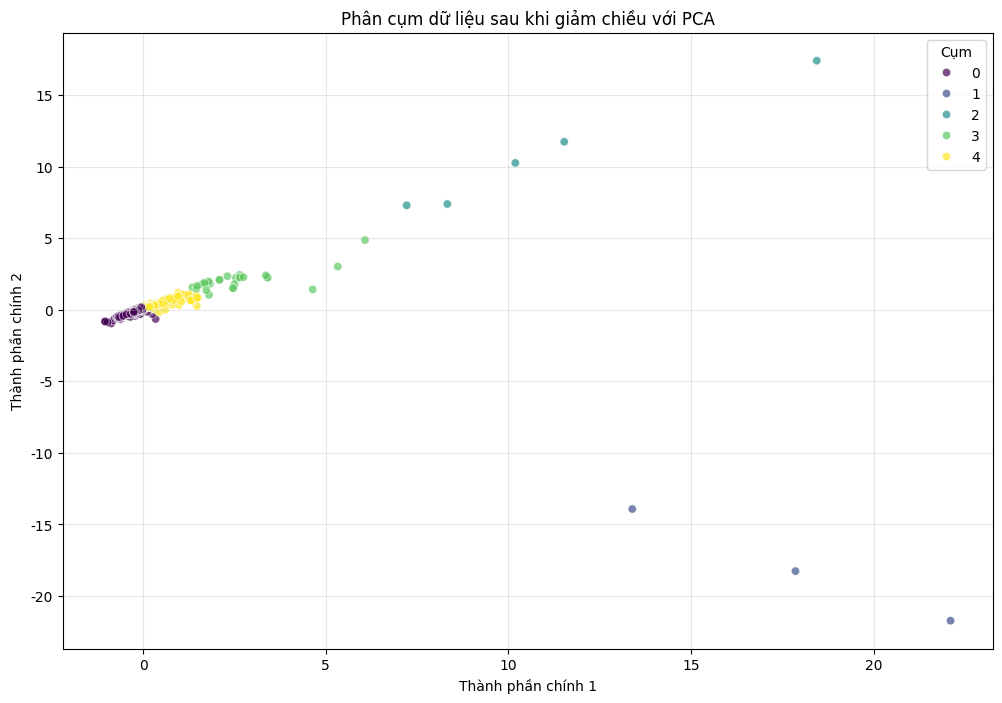

In [29]:
# 14. Phân tích PCA để trực quan hóa
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)
df_clean['pca1'] = pca_result[:, 0]
df_clean['pca2'] = pca_result[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df_clean, palette='viridis', alpha=0.7)
plt.title('Phân cụm dữ liệu sau khi giảm chiều với PCA')
plt.xlabel('Thành phần chính 1')
plt.ylabel('Thành phần chính 2')
plt.grid(True, alpha=0.3)
plt.legend(title='Cụm')
plt.show()

In [30]:
# 15. Đánh giá và phân tích mô hình
# Điểm silhouette score sau khi phân cụm
final_silhouette = silhouette_score(features_scaled, df_clean['cluster'])
print(f"\nSilhouette Score: {final_silhouette:.4f}")

# Ý nghĩa của từng cụm
print("\nÝ nghĩa của từng cụm:")
for i in range(optimal_k):
    cluster_data = df_clean[df_clean['cluster'] == i]
    print(f"\nCụm {i}:")
    if cluster_data['price_billion'].mean() > df_clean['price_billion'].mean() * 1.5:
        price_level = "Cao cấp"
    elif cluster_data['price_billion'].mean() < df_clean['price_billion'].mean() * 0.5:
        price_level = "Bình dân"
    else:
        price_level = "Trung cấp"

    if cluster_data['area_m2'].mean() > df_clean['area_m2'].mean() * 1.3:
        size_level = "Rộng"
    elif cluster_data['area_m2'].mean() < df_clean['area_m2'].mean() * 0.7:
        size_level = "Nhỏ"
    else:
        size_level = "Trung bình"

    print(f"Phân khúc: {price_level}, Diện tích: {size_level}")
    print(f"Giá trung bình: {cluster_data['price_billion'].mean():.2f} tỷ VNĐ")
    print(f"Diện tích trung bình: {cluster_data['area_m2'].mean():.2f} m²")
    print(f"Giá/m² trung bình: {(cluster_data['price_per_m2'] / 1000000).mean():.2f} triệu VNĐ/m²")

    # Top vị trí
    top_locations = cluster_data['location_cleaned'].value_counts().head(3)
    print("Top vị trí phổ biến:")
    for loc, count in top_locations.items():
        percentage = (count / len(cluster_data)) * 100
        print(f"- {loc}: {percentage:.1f}% ({count} căn)")


Silhouette Score: 0.5940

Ý nghĩa của từng cụm:

Cụm 0:
Phân khúc: Trung cấp, Diện tích: Trung bình
Giá trung bình: 2.28 tỷ VNĐ
Diện tích trung bình: 61.69 m²
Giá/m² trung bình: 40.18 triệu VNĐ/m²
Top vị trí phổ biến:
- Quận 9: 14.9% (235 căn)
- Quận 2 - Thủ Đức: 13.5% (212 căn)
- Quận 1: 13.3% (209 căn)

Cụm 1:
Phân khúc: Cao cấp, Diện tích: Trung bình
Giá trung bình: 653.33 tỷ VNĐ
Diện tích trung bình: 67.67 m²
Giá/m² trung bình: 9778.20 triệu VNĐ/m²
Top vị trí phổ biến:
- Quận 8: 33.3% (1 căn)
- Huyện Bình Chánh: 33.3% (1 căn)
- Quận 9: 33.3% (1 căn)

Cụm 2:
Phân khúc: Cao cấp, Diện tích: Rộng
Giá trung bình: 9.95 tỷ VNĐ
Diện tích trung bình: 948.00 m²
Giá/m² trung bình: 10.58 triệu VNĐ/m²
Top vị trí phổ biến:
- Quận 2 - Thủ Đức: 20.0% (1 căn)
- Quận Tân Phú: 20.0% (1 căn)
- Huyện Hóc Môn: 20.0% (1 căn)

Cụm 3:
Phân khúc: Cao cấp, Diện tích: Rộng
Giá trung bình: 13.67 tỷ VNĐ
Diện tích trung bình: 259.41 m²
Giá/m² trung bình: 47.93 triệu VNĐ/m²
Top vị trí phổ biến:
- Huyện Nhà Bè: 1

In [33]:
# 16. Kết luận và đề xuất
print("\n KẾT LUẬN VÀ ĐỀ XUẤT ")
print("Dựa trên phân tích phân cụm K-means của dữ liệu bất động sản TP.HCM, có thể rút ra các kết luận và đề xuất sau:")

# Nhóm các cụm theo phân khúc thị trường
high_end_clusters = []
mid_range_clusters = []
affordable_clusters = []

for i in range(optimal_k):
    cluster_data = df_clean[df_clean['cluster'] == i]
    if cluster_data['price_billion'].mean() > df_clean['price_billion'].mean() * 1.5:
        high_end_clusters.append(i)
    elif cluster_data['price_billion'].mean() < df_clean['price_billion'].mean() * 0.5:
        affordable_clusters.append(i)
    else:
        mid_range_clusters.append(i)

print(f"\n1. Phân khúc cao cấp (Cụm {high_end_clusters}):")
print("- Đặc điểm: Diện tích lớn, giá cao, thường ở các quận trung tâm")
print("- Đề xuất: Phù hợp cho đầu tư dài hạn, cần tập trung vào chất lượng và tiện ích cao cấp")

print(f"\n2. Phân khúc trung cấp (Cụm {mid_range_clusters}):")
print("- Đặc điểm: Diện tích và giá ở mức trung bình, phân bố đều ở nhiều quận")
print("- Đề xuất: Phân khúc có tính thanh khoản tốt, phù hợp cho cả đầu tư và ở thực")

print(f"\n3. Phân khúc bình dân (Cụm {affordable_clusters}):")
print("- Đặc điểm: Diện tích nhỏ, giá thấp, thường ở các quận xa trung tâm")
print("- Đề xuất: Phù hợp cho khách hàng có ngân sách hạn chế, tiềm năng tăng giá khi hạ tầng phát triển")

print("\n4. Đề xuất chung:")
print("- Nhà đầu tư nên xem xét tiềm năng phát triển hạ tầng của từng khu vực")
print("- Cân nhắc các yếu tố như kết nối giao thông, tiện ích xung quanh khi lựa chọn bất động sản")
print("- Phân khúc trung cấp có thể là lựa chọn cân bằng giữa khả năng sinh lời và tính thanh khoản")


 KẾT LUẬN VÀ ĐỀ XUẤT 
Dựa trên phân tích phân cụm K-means của dữ liệu bất động sản TP.HCM, có thể rút ra các kết luận và đề xuất sau:

1. Phân khúc cao cấp (Cụm [1, 2, 3]):
- Đặc điểm: Diện tích lớn, giá cao, thường ở các quận trung tâm
- Đề xuất: Phù hợp cho đầu tư dài hạn, cần tập trung vào chất lượng và tiện ích cao cấp

2. Phân khúc trung cấp (Cụm [0, 4]):
- Đặc điểm: Diện tích và giá ở mức trung bình, phân bố đều ở nhiều quận
- Đề xuất: Phân khúc có tính thanh khoản tốt, phù hợp cho cả đầu tư và ở thực

3. Phân khúc bình dân (Cụm []):
- Đặc điểm: Diện tích nhỏ, giá thấp, thường ở các quận xa trung tâm
- Đề xuất: Phù hợp cho khách hàng có ngân sách hạn chế, tiềm năng tăng giá khi hạ tầng phát triển

4. Đề xuất chung:
- Nhà đầu tư nên xem xét tiềm năng phát triển hạ tầng của từng khu vực
- Cân nhắc các yếu tố như kết nối giao thông, tiện ích xung quanh khi lựa chọn bất động sản
- Phân khúc trung cấp có thể là lựa chọn cân bằng giữa khả năng sinh lời và tính thanh khoản


 SO SÁNH VỚI THUẬT TOÁN DBSCAN

In [34]:
# Import thêm thư viện cần thiết cho DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import time

In [35]:
# 1.Chuẩn bị dữ liệu cho DBSCAN
# Sử dụng cùng dữ liệu đã chuẩn hóa như K-means
features_for_dbscan = features_scaled.copy()

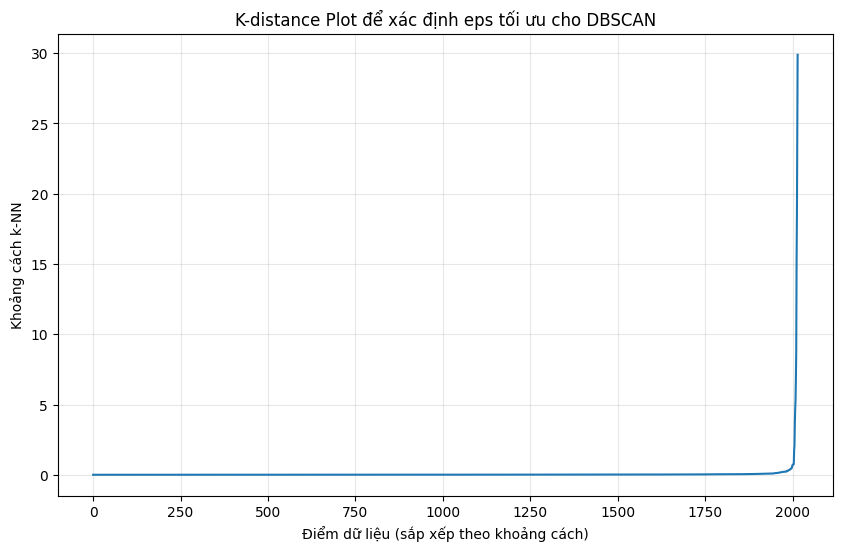

Eps được đề xuất: 0.0674


In [36]:
# 2.Tìm tham số tối ưu cho DBSCAN (eps và min_samples)
# Sử dụng k-distance plot để tìm eps tối ưu
k = 5  # Số điểm lân cận gần nhất
nbrs = NearestNeighbors(n_neighbors=k).fit(features_for_dbscan)
distances, indices = nbrs.kneighbors(features_for_dbscan)

# Sắp xếp khoảng cách và vẽ biểu đồ k-distance
distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Plot để xác định eps tối ưu cho DBSCAN')
plt.xlabel('Điểm dữ liệu (sắp xếp theo khoảng cách)')
plt.ylabel('Khoảng cách k-NN')
plt.grid(True, alpha=0.3)
plt.show()

# Chọn eps dựa trên "knee" của biểu đồ
eps_optimal = np.percentile(distances, 95)  # Chọn percentile 95 làm điểm bắt đầu
print(f"Eps được đề xuất: {eps_optimal:.4f}")

In [37]:
# 3. Thử nghiệm với nhiều giá trị eps và min_samples
eps_values = [eps_optimal * 0.5, eps_optimal, eps_optimal * 1.5, eps_optimal * 2.0]
min_samples_values = [3, 5, 10, 15]

dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(features_for_dbscan)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters > 1:  # Chỉ tính silhouette score khi có ít nhất 2 cụm
            try:
                silhouette_avg = silhouette_score(features_for_dbscan, labels)
            except:
                silhouette_avg = -1
        else:
            silhouette_avg = -1

        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette_score': silhouette_avg
        })

# Chọn tham số tốt nhất cho DBSCAN
dbscan_results_df = pd.DataFrame(dbscan_results)
dbscan_results_df = dbscan_results_df[dbscan_results_df['silhouette_score'] > 0]
if len(dbscan_results_df) > 0:
    best_dbscan = dbscan_results_df.loc[dbscan_results_df['silhouette_score'].idxmax()]
    print(f"\nTham số DBSCAN tốt nhất:")
    print(f"eps: {best_dbscan['eps']:.4f}")
    print(f"min_samples: {int(best_dbscan['min_samples'])}")
    print(f"Số cụm: {int(best_dbscan['n_clusters'])}")
    print(f"Số điểm nhiễu: {int(best_dbscan['n_noise'])}")
    print(f"Silhouette Score: {best_dbscan['silhouette_score']:.4f}")
else:
    # Sử dụng tham số mặc định nếu không tìm được tham số tốt
    best_dbscan = {'eps': eps_optimal, 'min_samples': 5}
    print(f"Sử dụng tham số mặc định: eps={eps_optimal:.4f}, min_samples=5")


Tham số DBSCAN tốt nhất:
eps: 0.1347
min_samples: 5
Số cụm: 3
Số điểm nhiễu: 50
Silhouette Score: 0.6783


In [38]:
# 4. Áp dụng DBSCAN với tham số tối ưu
start_time = time.time()
# Chuyển đổi min_samples thành int để tránh lỗi
eps_value = float(best_dbscan['eps'])
min_samples_value = int(best_dbscan['min_samples'])
dbscan_final = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan_labels = dbscan_final.fit_predict(features_for_dbscan)
dbscan_time = time.time() - start_time

# Thêm kết quả DBSCAN vào DataFrame
df_clean['dbscan_cluster'] = dbscan_labels

In [39]:
# 5. So sánh thời gian thực thi
start_time = time.time()
kmeans_comparison = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_comparison.fit(features_for_dbscan)
kmeans_time = time.time() - start_time

print(f"\n So Sánh Thời Gian Thực Thi Của 2 Thuật Toán")
print(f"K-Means: {kmeans_time:.4f} giây")
print(f"DBSCAN: {dbscan_time:.4f} giây")


 So Sánh Thời Gian Thực Thi Của 2 Thuật Toán
K-Means: 0.0297 giây
DBSCAN: 0.0383 giây


In [40]:
# 6. So sánh các chỉ số đánh giá
# Tính toán các chỉ số cho K-means
kmeans_silhouette = silhouette_score(features_for_dbscan, df_clean['cluster'])
kmeans_n_clusters = len(df_clean['cluster'].unique())

# Tính toán các chỉ số cho DBSCAN
dbscan_n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_n_noise = list(dbscan_labels).count(-1)

if dbscan_n_clusters > 1:
    # Loại bỏ điểm nhiễu khi tính silhouette score
    mask = dbscan_labels != -1
    if np.sum(mask) > 1:
        dbscan_silhouette = silhouette_score(features_for_dbscan[mask], dbscan_labels[mask])
    else:
        dbscan_silhouette = -1
else:
    dbscan_silhouette = -1

# So sánh
if len(df_clean['cluster'].unique()) == dbscan_n_clusters:
    ari_score = adjusted_rand_score(df_clean['cluster'], dbscan_labels)
    nmi_score = normalized_mutual_info_score(df_clean['cluster'], dbscan_labels)
else:
    ari_score = "N/A (số cụm khác nhau)"
    nmi_score = "N/A (số cụm khác nhau)"

print(f"\n                BẢNG SO SÁNH CHI TIẾT ")
comparison_table = pd.DataFrame({
    'Chỉ số': ['Số cụm', 'Silhouette Score', 'Thời gian (giây)', 'Điểm nhiễu', 'ARI Score', 'NMI Score'],
    'K-Means': [kmeans_n_clusters, f"{kmeans_silhouette:.4f}", f"{kmeans_time:.4f}", 0,
                f"{ari_score}" if isinstance(ari_score, str) else f"{ari_score:.4f}",
                f"{nmi_score}" if isinstance(nmi_score, str) else f"{nmi_score:.4f}"],
    'DBSCAN': [dbscan_n_clusters, f"{dbscan_silhouette:.4f}" if dbscan_silhouette > 0 else "N/A",
               f"{dbscan_time:.4f}", dbscan_n_noise, "Reference", "Reference"]
})
print(comparison_table.to_string(index=False))


                BẢNG SO SÁNH CHI TIẾT 
          Chỉ số                K-Means    DBSCAN
          Số cụm                      5         3
Silhouette Score                 0.5940    0.7110
Thời gian (giây)                 0.0297    0.0383
      Điểm nhiễu                      0        50
       ARI Score N/A (số cụm khác nhau) Reference
       NMI Score N/A (số cụm khác nhau) Reference


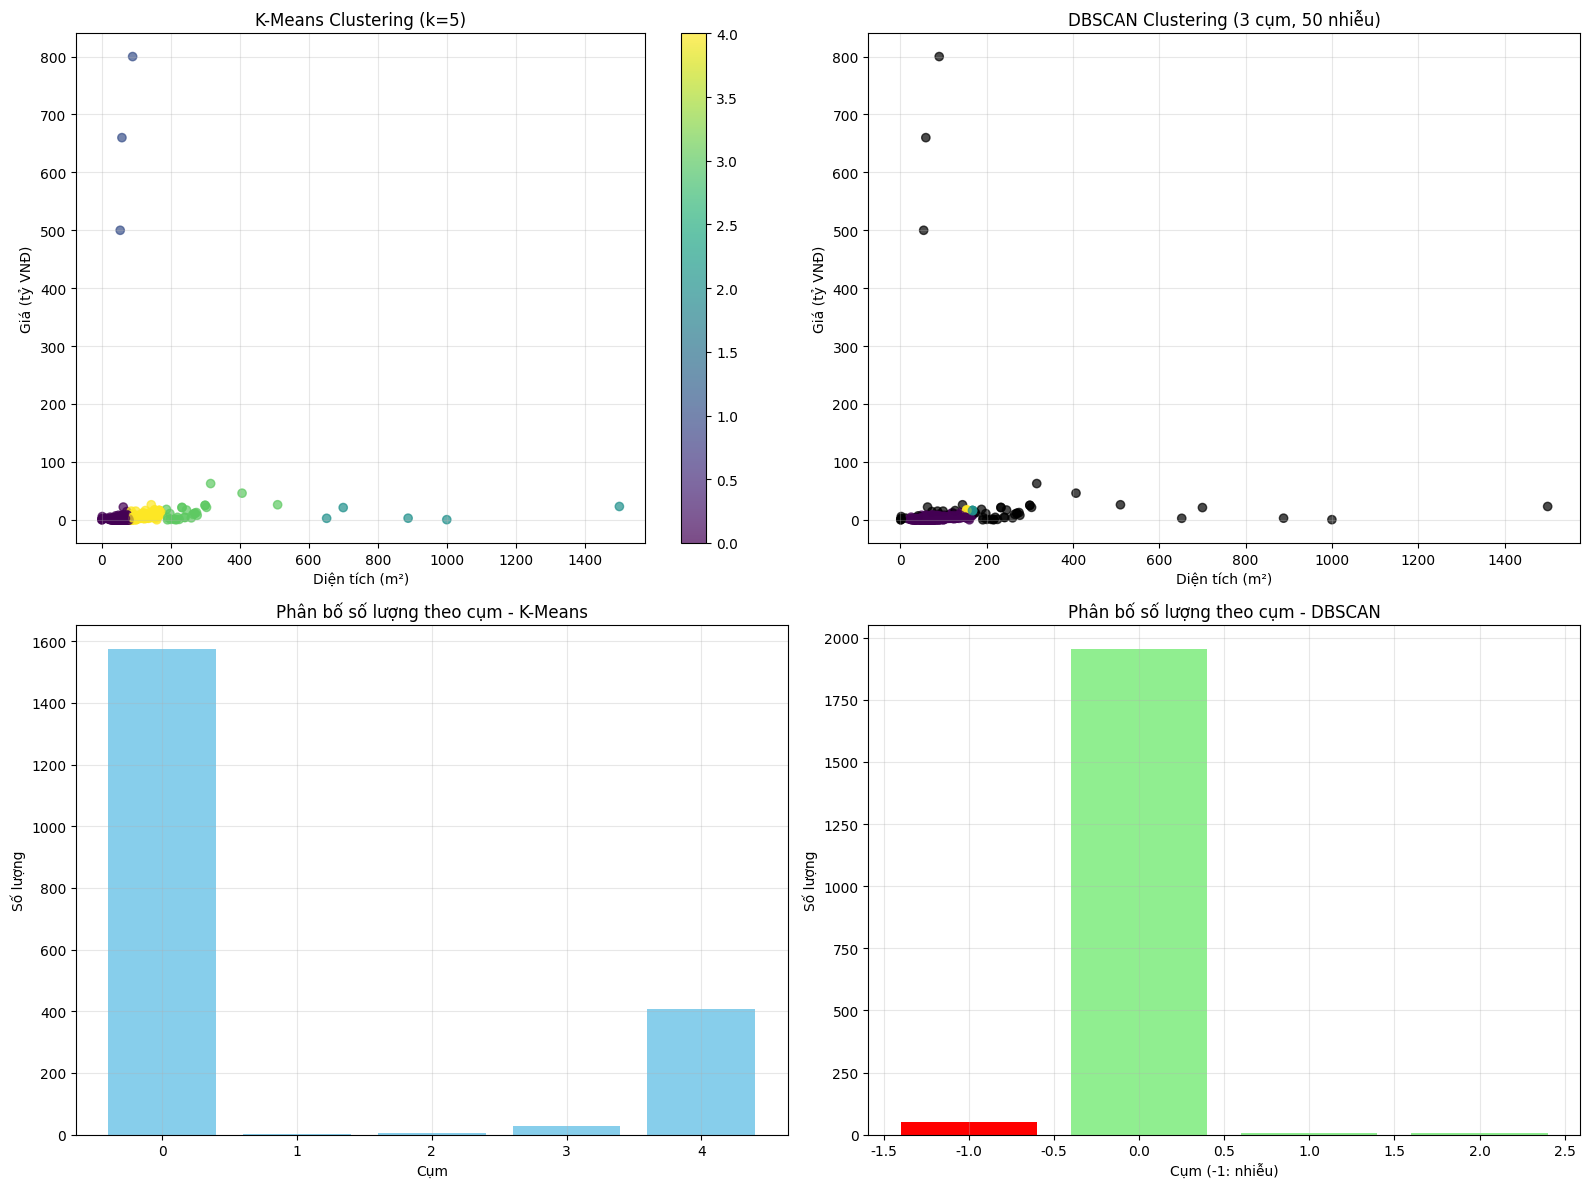

In [41]:
# 7. Trực quan hóa so sánh kết quả
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# K-Means
scatter1 = axes[0, 0].scatter(df_clean['area_m2'], df_clean['price_billion'],
                              c=df_clean['cluster'], cmap='viridis', alpha=0.7)
axes[0, 0].set_title(f'K-Means Clustering (k={optimal_k})')
axes[0, 0].set_xlabel('Diện tích (m²)')
axes[0, 0].set_ylabel('Giá (tỷ VNĐ)')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0])

# DBSCAN
# Tạo màu sắc cho DBSCAN (điểm nhiễu có màu đen)
colors = plt.cm.viridis(np.linspace(0, 1, dbscan_n_clusters))
dbscan_colors = []
for label in dbscan_labels:
    if label == -1:
        dbscan_colors.append('black')  # Điểm nhiễu
    else:
        dbscan_colors.append(colors[label])

scatter2 = axes[0, 1].scatter(df_clean['area_m2'], df_clean['price_billion'],
                              c=dbscan_colors, alpha=0.7)
axes[0, 1].set_title(f'DBSCAN Clustering ({dbscan_n_clusters} cụm, {dbscan_n_noise} nhiễu)')
axes[0, 1].set_xlabel('Diện tích (m²)')
axes[0, 1].set_ylabel('Giá (tỷ VNĐ)')
axes[0, 1].grid(True, alpha=0.3)

# Biểu đồ phân bố cụm cho K-Means
cluster_counts_kmeans = df_clean['cluster'].value_counts().sort_index()
axes[1, 0].bar(cluster_counts_kmeans.index, cluster_counts_kmeans.values, color='skyblue')
axes[1, 0].set_title('Phân bố số lượng theo cụm - K-Means')
axes[1, 0].set_xlabel('Cụm')
axes[1, 0].set_ylabel('Số lượng')
axes[1, 0].grid(True, alpha=0.3)

# Biểu đồ phân bố cụm cho DBSCAN
dbscan_counts = pd.Series(dbscan_labels).value_counts().sort_index()
colors_bar = ['red' if idx == -1 else 'lightgreen' for idx in dbscan_counts.index]
axes[1, 1].bar(dbscan_counts.index, dbscan_counts.values, color=colors_bar)
axes[1, 1].set_title('Phân bố số lượng theo cụm - DBSCAN')
axes[1, 1].set_xlabel('Cụm (-1: nhiễu)')
axes[1, 1].set_ylabel('Số lượng')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [42]:
# 8. Phân tích kết quả cụ thể cho dữ liệu bất động sản
print(f"\n KẾT QUẢ PHÂN TÍCH CHO DỮ LIỆU BẤT ĐỘNG SẢN ")

if dbscan_n_clusters > 0:
    print(f"\nK-Means tạo ra {kmeans_n_clusters} cụm đều với kích thước:")
    for i in range(kmeans_n_clusters):
        count = len(df_clean[df_clean['cluster'] == i])
        percentage = (count / len(df_clean)) * 100
        print(f"- Cụm {i}: {count} căn hộ ({percentage:.1f}%)")

    print(f"\nDBSCAN tạo ra {dbscan_n_clusters} cụm chính và {dbscan_n_noise} điểm nhiễu:")
    for label in sorted(set(dbscan_labels)):
        count = list(dbscan_labels).count(label)
        percentage = (count / len(dbscan_labels)) * 100
        if label == -1:
            print(f"- Nhiễu: {count} căn hộ ({percentage:.1f}%) - có thể là bất động sản đặc biệt")
        else:
            print(f"- Cụm {label}: {count} căn hộ ({percentage:.1f}%)")


 KẾT QUẢ PHÂN TÍCH CHO DỮ LIỆU BẤT ĐỘNG SẢN 

K-Means tạo ra 5 cụm đều với kích thước:
- Cụm 0: 1574 căn hộ (78.1%)
- Cụm 1: 3 căn hộ (0.1%)
- Cụm 2: 5 căn hộ (0.2%)
- Cụm 3: 27 căn hộ (1.3%)
- Cụm 4: 406 căn hộ (20.1%)

DBSCAN tạo ra 3 cụm chính và 50 điểm nhiễu:
- Nhiễu: 50 căn hộ (2.5%) - có thể là bất động sản đặc biệt
- Cụm 0: 1953 căn hộ (96.9%)
- Cụm 1: 5 căn hộ (0.2%)
- Cụm 2: 7 căn hộ (0.3%)
